In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

In [2]:
from zipfile import ZipFile
data_path = 'dog-breed-identification.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')


The data set has been extracted.


In [5]:
df = pd.read_csv('labels.csv')
df.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
df.shape


(10222, 2)

In [9]:
df['breed'].nunique()


120

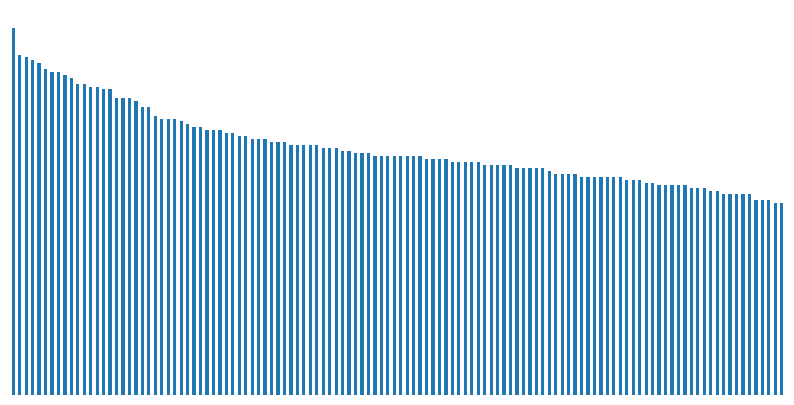

In [11]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()


In [13]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


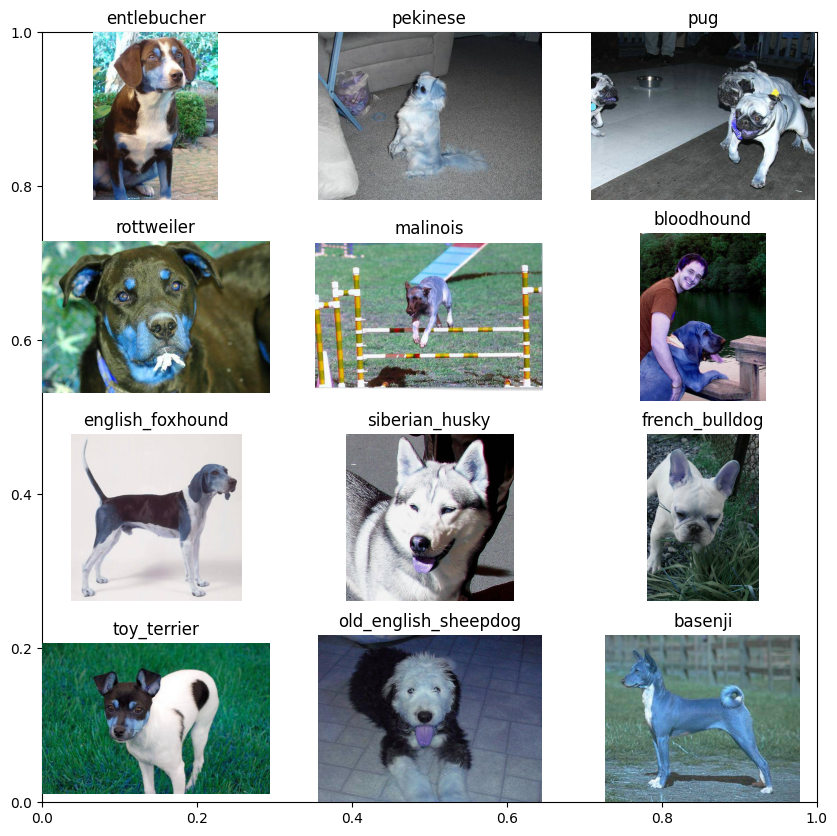

In [15]:
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image
    # index from the dataframe.
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()


In [17]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [19]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape


((8688,), (1534,))

In [21]:
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])


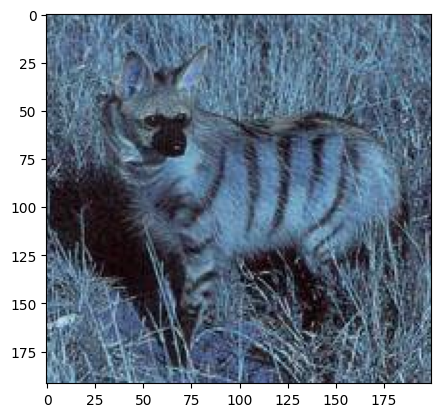

In [23]:
img = cv2.imread('train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()


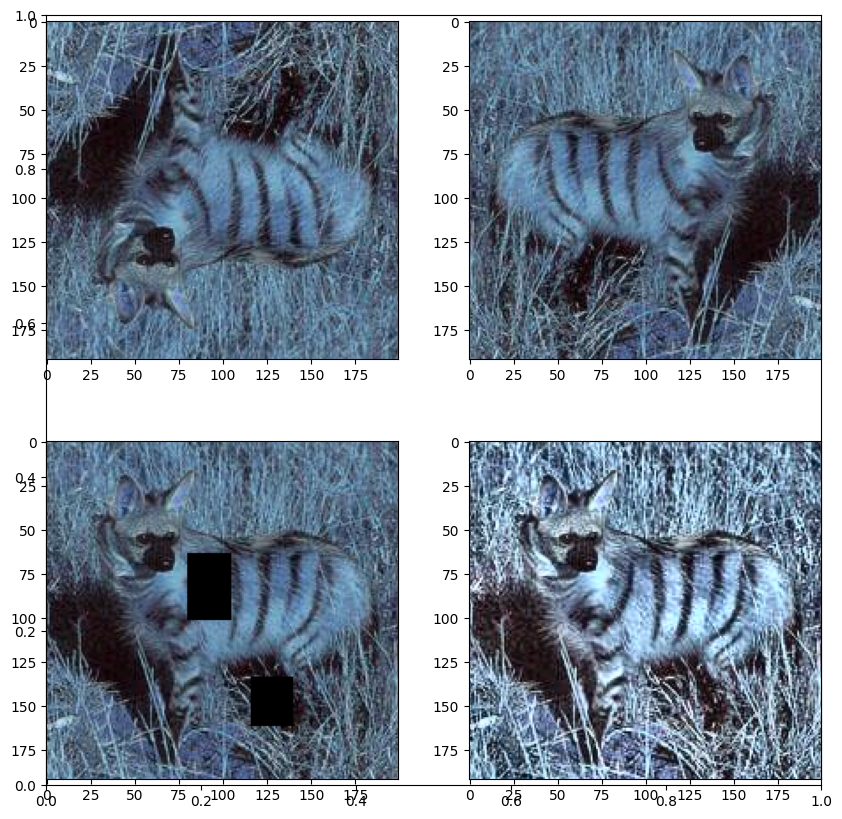

In [25]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
plt.show()


In [27]:
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']

    return aug_img


@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)

    return img, label


def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label,
                           depth=120,
                           dtype=tf.float32)


In [29]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


In [31]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)


(32, 128, 128, 3) (32, 120)


In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)


In [35]:
for layer in pre_trained_model.layers: 
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7') 
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape) 
last_output = last_layer.output


last layer output shape:  (None, 6, 6, 768)


In [37]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC()]
)


In [39]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
            print('\n Validation accuracy has reached upto 90% so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3,
                monitor='val_auc',
                restore_best_weights=True,
                mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',
                    patience=2,
                    factor=0.5,
                    verbose=1)


In [41]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])


Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 145s 484ms/step - auc: 0.7183 - loss: 4.3533 - val_auc: 0.9399 - val_loss: 2.5837 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 119s 439ms/step - auc: 0.9640 - loss: 2.1999 - val_auc: 0.9368 - val_loss: 2.3814 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 120s 439ms/step - auc: 0.9918 - loss: 1.1879 - val_auc: 0.9303 - val_loss: 2.3836 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - auc: 0.9993 - loss: 0.5049
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 ━━━━━━━━━━━━━━━━━━━━ 115s 424ms/step - auc: 0.9993 - loss: 0.5046 - val_auc: 0.9187 - val_loss: 2.4502 - learning_rate: 0.0010


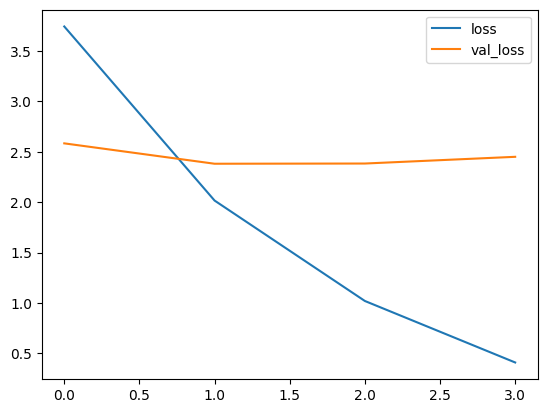

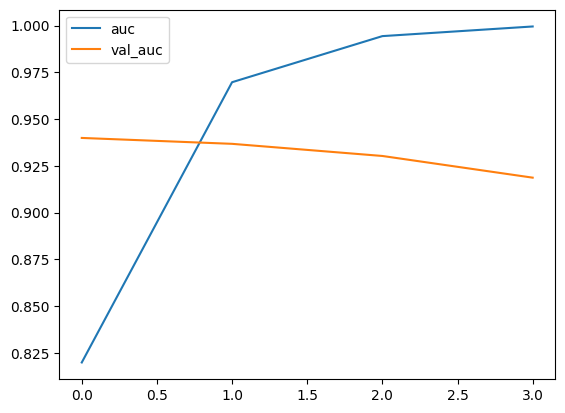

In [43]:
history_df = pd.DataFrame(history.history) 
history_df.loc[:, ['loss', 'val_loss']].plot() 
history_df.loc[:, ['auc', 'val_auc']].plot() 
plt.show()


In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [59]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = 'path_to_your_dog_image.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize based on your model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if required

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted Dog Breed Class: {predicted_class}")


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_dog_image.jpg'

In [63]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = 'dog.jpg'  # Updated image path
img = image.load_img(img_path, target_size=(128, 128))  # Resize to (128, 128)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if required

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted Dog Breed Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Dog Breed Class: [102]


In [67]:
class_indices = {0: 'Beagle', 1: 'Labrador Retriever', 102: 'Golden'}  # Example mapping
breed_name = class_indices.get(predicted_class[0], "Unknown Breed")
print(f"Predicted Dog Breed: {breed_name}")


Predicted Dog Breed: Golden


In [69]:
class_indices = {0: 'Beagle', 1: 'Labrador Retriever', 102: 'Golden Retriever'}  # Example mapping
breed_name = class_indices.get(predicted_class[0], "Unknown Breed")
print(f"Predicted Dog Breed: {breed_name}")


Predicted Dog Breed: Golden Retriever


In [71]:
print(train_generator.class_indices)  # If you used ImageDataGenerator



NameError: name 'train_generator' is not defined

In [75]:
# Create a mapping of breed names to class indices
breed_to_index = {breed: idx for idx, breed in enumerate(df['breed'].unique())}

# Create a reverse mapping from class index to breed name
index_to_breed = {idx: breed for breed, idx in breed_to_index.items()}

# Example usage
predicted_class = 101  # Change this to your model output
breed_name = index_to_breed.get(predicted_class, "Unknown Breed")

print(f"Predicted Dog Breed: {breed_name}")


Predicted Dog Breed: 105


In [78]:
# Create a mapping of breed names to class indices
breed_to_index = {breed: idx for idx, breed in enumerate(df['breed'].unique())}

# Create a reverse mapping from class index to breed name
index_to_breed = {idx: breed for breed, idx in breed_to_index.items()}

# Example usage
predicted_class = 101  # Change this to your model output
breed_name = index_to_breed.get(predicted_class, "Unknown Breed")

print(f"Predicted Dog Breed: {breed_name}")


Predicted Dog Breed: 105


In [80]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = 'dog2.png'  # Updated image path
img = image.load_img(img_path, target_size=(128, 128))  # Resize to (128, 128)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if required

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted Dog Breed Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted Dog Breed Class: [54]


In [84]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = 'image_2025-03-24_042916287.png'  # Updated image path
img = image.load_img(img_path, target_size=(128, 128))  # Resize to (128, 128)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if required

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted Dog Breed Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Dog Breed Class: [74]


In [88]:
# Load the mapping of class indices to breed names
import json

with open("class_indices.json", "r") as f:  # Path to your class indices file
    class_indices = json.load(f)

# Reverse the dictionary to get index-to-breed mapping
index_to_breed = {v: k for k, v in class_indices.items()}

# Get the predicted breed name
predicted_breed = index_to_breed.get(predicted_class[0], "Unknown Breed")
print(f"Predicted Dog Breed: {predicted_breed}")


FileNotFoundError: [Errno 2] No such file or directory: 'class_indices.json'

In [90]:
# Check if you have the training data generator
print(train_generator.class_indices)  # Uncomment to see the mapping

# Reverse the dictionary to get index-to-breed mapping
index_to_breed = {v: k for k, v in train_generator.class_indices.items()}

# Get the predicted breed name
predicted_breed = index_to_breed.get(predicted_class[0], "Unknown Breed")
print(f"Predicted Dog Breed: {predicted_breed}")


NameError: name 'train_generator' is not defined

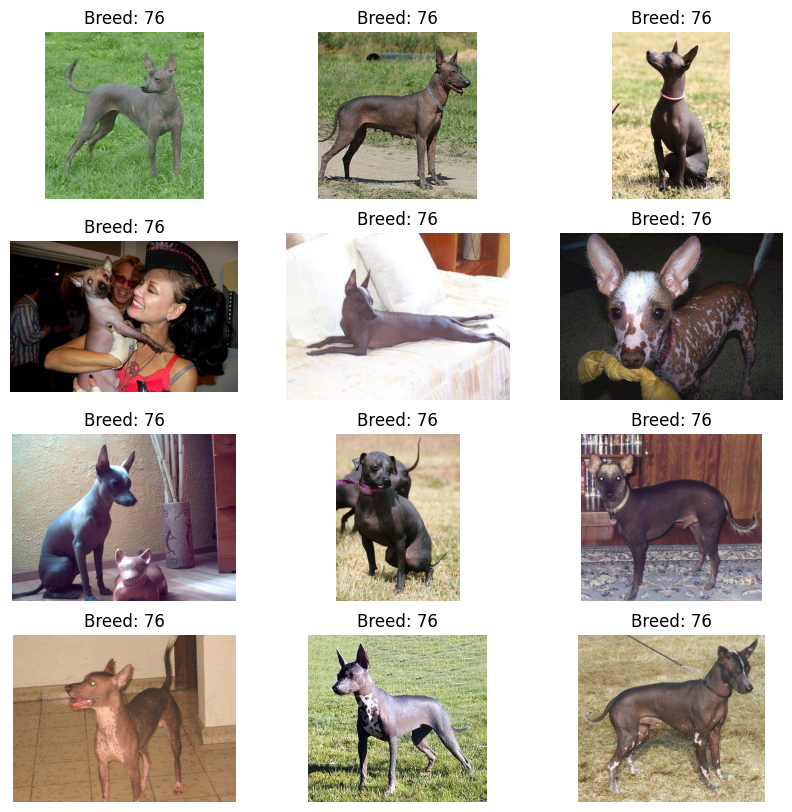

In [94]:
breed_76_df = df[df['breed'] == 76]  # Assuming 'breed' column has numeric labels

# If breed names are stored as strings and you have a mapping:
# breed_74_df = df[df['breed'] == "breed_name_for_74"]

plt.figure(figsize=(10, 10))

for i in range(12):
    plt.subplot(4, 3, i + 1)
    
    # Randomly select an image of breed 74
    k = np.random.randint(0, len(breed_76_df))
    img_path = breed_74_df.iloc[k]['filepath']  # Assuming 'filepath' column has image paths
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB for correct color display
    plt.imshow(img)
    plt.title(f"Breed: 76")
    plt.axis('off')

plt.show()
